In [1]:
pip install fastai --upgrade

     |████████████████████████████████| 189 kB 5.5 MB/s 
     |████████████████████████████████| 56 kB 4.3 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [2]:
! nvidia-smi

Sun Nov 28 19:55:55 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    32W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%time 
import fastai
from fastai.vision.all import *

CPU times: user 1.41 s, sys: 824 ms, total: 2.23 s
Wall time: 6.62 s


In [5]:
%%time
path = untar_data(URLs.IMAGENETTE)

CPU times: user 17.2 s, sys: 9.98 s, total: 27.2 s
Wall time: 48.5 s


In [6]:
%%time
dblocks = DataBlock(blocks = (ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    get_y = parent_label,
                    item_tfms = Resize(460),
                    batch_tfms = aug_transforms(size = 224, min_scale = 0.75))

CPU times: user 5.19 ms, sys: 155 µs, total: 5.34 ms
Wall time: 5.08 ms


In [7]:
%%time
dls = dblocks.dataloaders(path, bs = 64, device = "cuda")

CPU times: user 3.25 s, sys: 1.15 s, total: 4.41 s
Wall time: 10.4 s


/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


CPU times: user 1.14 s, sys: 70.9 ms, total: 1.21 s
Wall time: 1.26 s


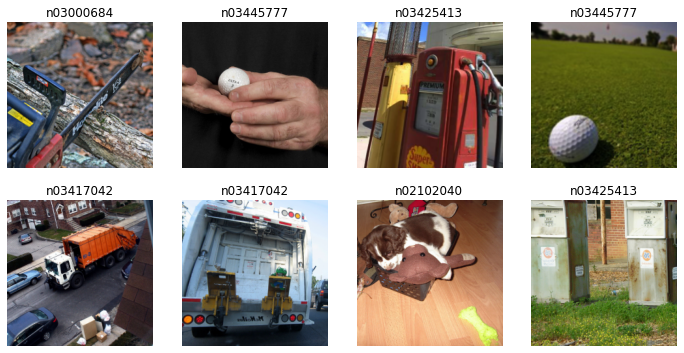

In [8]:
%%time
dls.show_batch(max_n = 8)

In [8]:
## baseline model

model = xresnet50()
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.638539,2.575586,0.403286,05:17
1,1.231072,1.342110,0.582898,05:06
2,0.938300,1.049725,0.666916,05:05
3,0.718947,0.737317,0.764376,05:05


epoch,train_loss,valid_loss,accuracy,time
0,1.638539,2.575586,0.403286,05:17
1,1.231072,1.342110,0.582898,05:06
2,0.938300,1.049725,0.666916,05:05
3,0.718947,0.737317,0.764376,05:05
4,0.603890,0.534341,0.831964,05:06


In [8]:
x,y = dls.one_batch()

print (x.shape, y.shape)

torch.Size([64, 3, 224, 224]) torch.Size([64])


In [9]:
x.mean(dim = [0,2,3]), x.std(dim = [0,2,3])

(TensorImage([0.4467, 0.4326, 0.4036], device='cuda:0'),
 TensorImage([0.2903, 0.2872, 0.3013], device='cuda:0'))

In [9]:
def get_dls(bs, size):
  dblock = DataBlock(blocks = (ImageBlock, CategoryBlock),
                     get_items = get_image_files,
                     get_y = parent_label,
                     item_tfms = Resize(460),
                     batch_tfms = [*aug_transforms(size = size, min_scale = 0.75),
                                   Normalize.from_stats(*imagenet_stats)])
  return dblock.dataloaders(path, bs = bs, device = "cuda")

In [11]:
dls = get_dls(64, 224)

In [12]:
x,y = dls.one_batch()

In [13]:
x.mean(dim = [0,2,3]), x.std(dim = [0,2,3])

(TensorImage([-0.1101,  0.0446,  0.1966], device='cuda:0'),
 TensorImage([1.1972, 1.2296, 1.3499], device='cuda:0'))

In [14]:
model = xresnet50()
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.641431,2.216357,0.474234,05:08
1,1.275698,1.203614,0.637416,04:57
2,0.981115,1.586287,0.556012,04:58
3,0.781165,0.709825,0.781553,04:57
4,0.621348,0.576928,0.818148,04:57


In [15]:
## progressive resizing

In [7]:
dls = get_dls(128,128)

In [8]:
x,y = dls.one_batch()

In [9]:
print (x.shape, y.shape)

torch.Size([128, 3, 128, 128]) torch.Size([128])


In [16]:
! nvidia-smi

Sat Nov 27 18:56:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    61W / 149W |   6326MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
torch.cuda.empty_cache()

In [13]:
learn = Learner(dls, xresnet50(), loss_func = CrossEntropyLossFlat(), metrics = accuracy)
learn.fit_one_cycle(n_epoch = 4, lr_max = 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.887941,1.903223,0.414115,03:03
1,1.314820,1.255913,0.595220,02:59
2,0.971128,0.814889,0.744212,02:58
3,0.748717,0.688046,0.785661,02:57


In [17]:
learn.dls = get_dls(64, 224)
learn.fine_tune(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.848104,0.880693,0.724048,05:06


epoch,train_loss,valid_loss,accuracy,time
0,0.645749,0.766066,0.756908,04:53
1,0.656260,0.827133,0.744212,04:54
2,0.592894,0.631163,0.803958,04:55
3,0.498515,0.487493,0.848021,04:54
4,0.438453,0.470330,0.849515,04:54


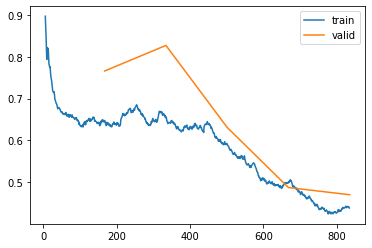

In [19]:
learn.recorder.plot_loss()

In [20]:
## test time augmentation

preds, targs = learn.tta()

In [21]:
accuracy(preds, targs).item()

0.8539955019950867

In [22]:
preds, targs = learn.tta(use_max = True)

In [23]:
accuracy(preds, targs).item()

0.8573562502861023

In [10]:
## mixup

In [12]:
%%time
model = xresnet50()
learn = Learner(dls, model, loss_func = CrossEntropyLossFlat(), metrics = accuracy, cbs = MixUp())
learn.fit_one_cycle(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.928761,3.573360,0.254294,05:25
1,1.628962,1.477881,0.547423,05:11
2,1.437399,1.730721,0.482823,05:11
3,1.244525,0.766838,0.768484,05:10
4,1.125895,0.662692,0.801718,05:10


CPU times: user 13min 35s, sys: 9min 45s, total: 23min 21s
Wall time: 26min 10s


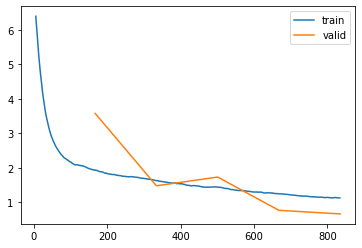

In [13]:
learn.recorder.plot_loss()

In [14]:
## Label Smoothing

In [15]:
%%time
model = xresnet34()
learn = Learner(dls, model, loss_func = LabelSmoothingCrossEntropy(), metrics = accuracy)
learn.fit_one_cycle(3, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.481337,2.560269,0.468260,03:14
1,1.966091,2.297964,0.584765,03:12
2,1.732941,1.684789,0.775952,03:13


CPU times: user 3min 41s, sys: 1min 31s, total: 5min 13s
Wall time: 9min 40s


CPU times: user 42 ms, sys: 1.41 ms, total: 43.4 ms
Wall time: 47.8 ms


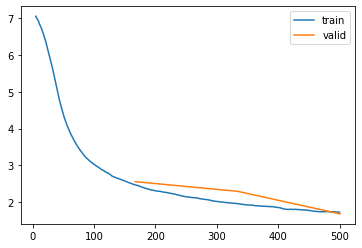

In [16]:
%%time
learn.recorder.plot_loss()

In [18]:
%%time
preds, targs = learn.tta(n = 2)

CPU times: user 29.4 s, sys: 1.97 s, total: 31.3 s
Wall time: 1min 40s


In [19]:
accuracy(preds, targs).item()

0.7766990065574646

In [ ]:
## key takeaways - progresive resizing helps when training from scratch
##                 normalization is needed when using pre trained network
##                 tta is like ensembling. It takes the avg of predictions or the majority vote
##                 mixup takes a linear combination of two images
##                 label smoothing helps to reduce over confidence of the model and increases robustness .